In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.12


In [2]:
# Imports
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Henrique Bardella" --iversions

Author: Henrique Bardella

torch      : 1.12.1
numpy      : 1.23.4
tensorflow : 2.10.0
matplotlib : 3.5.1
torchvision: 0.13.1



In [4]:
# Executar somente se a máquina tiver GPU e Plataforma CUDA instalada
!nvidia-smi

Fri Dec 23 14:34:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.56       Driver Version: 527.56       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   62C    P0    31W / 115W |    778MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# Verifica se a plataforma CUDA está disponível
train_on_gpu = torch.cuda.is_available()

In [6]:
# Mensagem para o usuário
if not train_on_gpu:
    print('Plataforma CUDA não está disponível. O treinamento será realizado com a CPU ...')
else:
    print('Plataforma CUDA está disponível! O treinamento será realizado com a GPU ...')

Plataforma CUDA não está disponível. O treinamento será realizado com a CPU ...


In [7]:
### Checando o Hardware Disponível no Servidor da DSA - CPU e GPUs

In [8]:
# Lista todos os dispositivos disponiveis
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5629508429605537925
xla_global_id: -1
]


In [9]:
import tensorflow as tf
print("Número Disponível de GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

Número Disponível de GPUs:  0


In [10]:
# Lista o código de cada GPU
tf.config.list_physical_devices('GPU')

[]

## Carregando o Dataset

http://pytorch.org/docs/stable/torchvision/datasets.html

O download pode demorar um minuto. Carregamos os dados de treinamento e teste, dividimos os dados de treinamento em um conjunto de treinamento e validação e, em seguida, criamos DataLoaders para cada um desses conjuntos de dados.


In [11]:
# Função que converte os dados em um tensor normalizado
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [12]:
# Download dos dados de treino
dados_treino = datasets.CIFAR10('dados', 
                                train = True,
                                download = True, 
                                transform = transform)

Files already downloaded and verified


In [15]:
# Download dos dados de teste
dados_teste = datasets.CIFAR10('dados', 
                               train = False,
                               download = True, 
                               transform = transform)

Files already downloaded and verified


## Preparando os Data Loaders

In [13]:
# Dados de treino
dados_treino

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: dados
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [16]:
# Dados de teste
dados_teste

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: dados
    Split: Test
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [17]:
# Número de amostras de treino
num_amostras_treino = len(dados_treino)
num_amostras_treino

50000

In [18]:
# Criamos um índice e o tornamos randômico
indices = list(range(num_amostras_treino))
np.random.shuffle(indices)

In [20]:
# Percentual dos dados de treino que usaremos no dataset de validação
valid_size = 0.2

In [21]:
# Agora fazemos o split para os dados de treino e validação
split = int(np.floor(valid_size * num_amostras_treino))
idx_treino, idx_valid = indices[split:], indices[:split]

In [22]:
# Definimos as amostras de treino
amostras_treino = SubsetRandomSampler(idx_treino)

In [23]:
# Definimos as amostras de validação
amostras_valid = SubsetRandomSampler(idx_valid)

>Agora preparamos os data loaders.

In [25]:
# Número de subprocessos para carregar os dados
num_workers = 0

In [26]:
# Número de amostras por batch
batch_size = 20

In [27]:
# Data Loader de dados de treino
loader_treino = torch.utils.data.DataLoader(dados_treino, 
                                            batch_size = batch_size, 
                                            sampler = amostras_treino, 
                                            num_workers = num_workers)

In [28]:
# Data Loader de dados de validação
loader_valid = torch.utils.data.DataLoader(dados_treino, 
                                           batch_size = batch_size, 
                                           sampler = amostras_valid, 
                                           num_workers = num_workers)

In [29]:
# Data Loader de dados de teste
loader_teste = torch.utils.data.DataLoader(dados_teste, 
                                           batch_size = batch_size, 
                                           num_workers = num_workers)

In [30]:
# Lista de classes das imagens
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Visualizando os Dados

In [32]:
# Função para desnormalização das imagens
 ## Desnormalizar para ver a imagem original
def imshow(img):
    
    # Desfaz a normalização
    img = img / 2 + 0.5  
    
    # Converte em tensor e imprime
    plt.imshow(np.transpose(img, (1, 2, 0))) 

In [33]:
# Obtém um batch de dados de treino
dataiter = iter(loader_treino)
images, labels = dataiter.next()

In [34]:
# Converte as imagens em formato NumPy
images = images.numpy() 

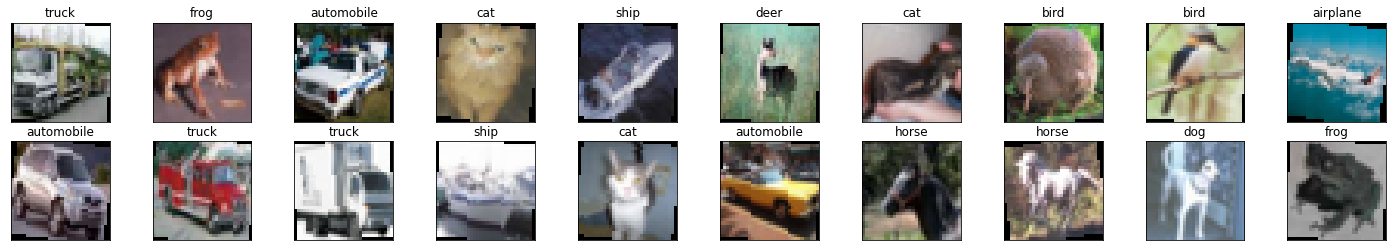

In [38]:
# Plot de um batch de imagens de treino

# Área de plotagem
fig = plt.figure(figsize = (25, 4))

# Loop e print
for idx in np.arange(20):
    
    # Cria os subplots
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    
    # Desfaz a normalização
    # images[idx]
    imshow(images[idx])
    
    # Coloca o título
    ax.set_title(classes[labels[idx]])

## Visualizando Uma Imagem em Mais Detalhes

Aqui, observamos os canais de cores normalizados de vermelho, verde e azul (RGB) como três imagens separadas com intensidade de tons de cinza.

In [39]:
# Extraímos os canais de cores
rgb_img = np.squeeze(images[3])
channels = ['Canal Vermelho (Red)', 'Canal Verde (Green)', 'Canal Azul (Blue)']

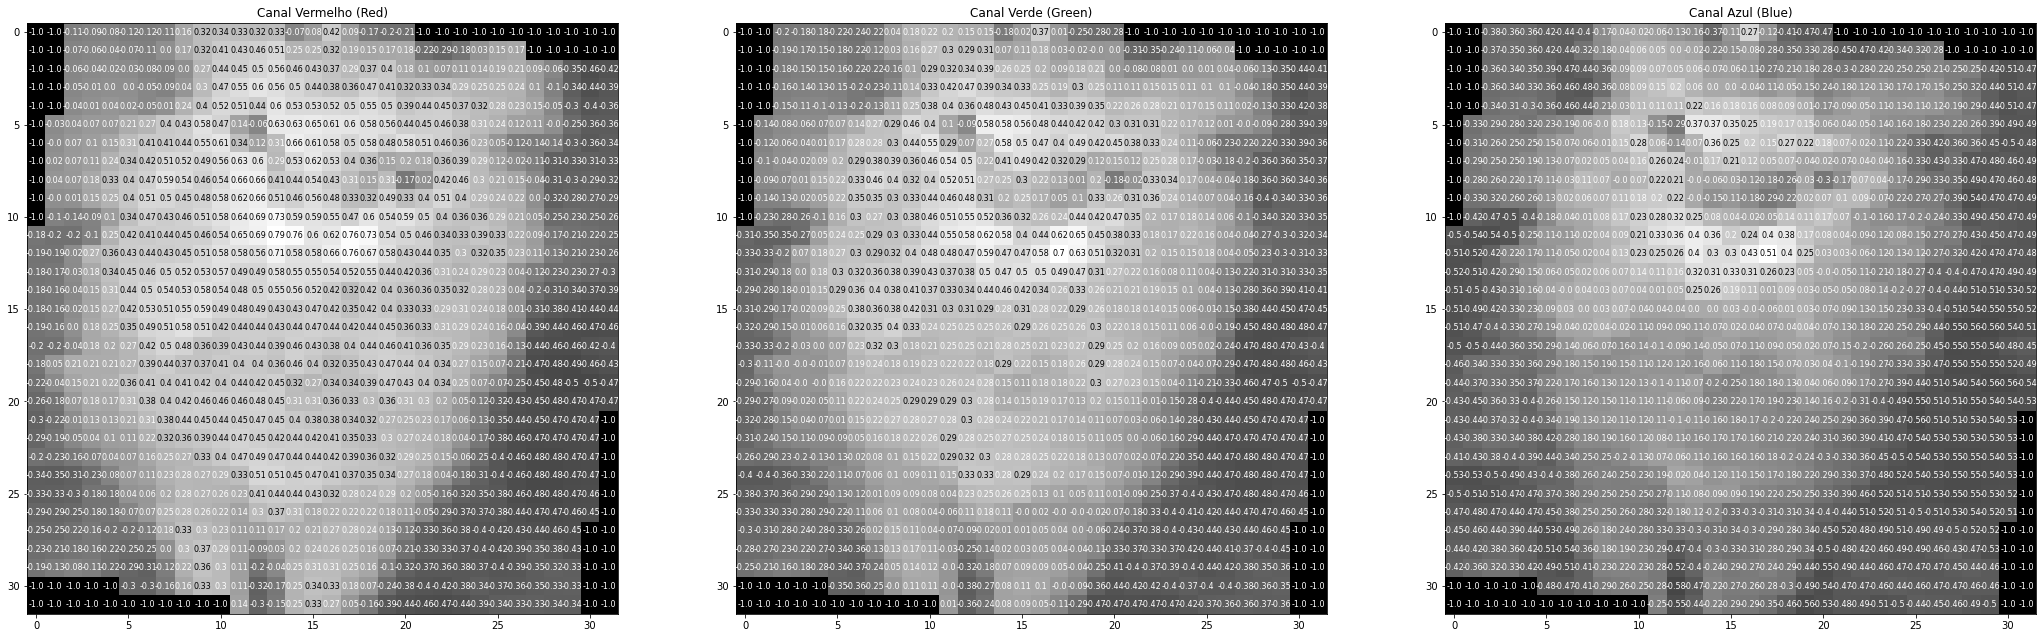

In [40]:
# Loop e print

# Área de plotagem
fig = plt.figure(figsize = (36, 36)) 

# Loop pelas imagens
for idx in np.arange(rgb_img.shape[0]):
    
    # Subplot
    ax = fig.add_subplot(1, 3, idx + 1)
    
    # Índice
    img = rgb_img[idx]
    
    # Mostra a imagem em escala de cinza
    ax.imshow(img, cmap = 'gray')
    
    # Título
    ax.set_title(channels[idx])
    
    # Largura e altura da imagem
    width, height = img.shape
    
    # Limite
    thresh = img.max()/2.5
    
    # Loop
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), 
                        xy = (y,x), 
                        horizontalalignment = 'center', 
                        verticalalignment = 'center', 
                        size = 8,
                        color = 'white' if img[x][y] < thresh else 'black')

## Definindo a Arquitetura da Rede

http://pytorch.org/docs/stable/nn.html

Vamos definir uma arquitetura CNN (Convolutional Neural Network). 

* [Camadas convolucionais](https://pytorch.org/docs/stable/nn.html#conv2d), podem ser consideradas como uma pilha de imagens filtradas.

* [Camadas de Maxpool](https://pytorch.org/docs/stable/nn.html#maxpool2d), reduzem o tamanho x-y de uma entrada, mantendo apenas os pixels mais _ativos_ da camada anterior.

* As camadas Linear + Dropout podem evitar sobreajuste e produzir uma saída de 10 dimensões.

In [41]:
# Arquitetura do Modelo
class ModeloCNN(nn.Module):
    
    # Método construtor
    def __init__(self):
        super(ModeloCNN, self).__init__()
        
        # Camada Convolucional de entrada 
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        
        # Camada Convolucional oculta 
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        
        # Camada Convolucional oculta 
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        
        # Camada de Max Pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Camada Totalmente Conectada 1
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        
        # Camada Totalmente Conectada 2
        self.fc2 = nn.Linear(500, 10)
        
        # Camada de Dropout (Regularização)
        self.dropout = nn.Dropout(0.5)
        
    # Método Forward
    def forward(self, x):
        
        # Adiciona uma camada de ativação Relu para cada camada convolucional
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Faz o "achatamento" da matriz resultante da convolução e cria um vetor
        x = x.view(-1, 64 * 4 * 4)
        
        # Adiciona uma camada de dropout para regularização
        x = self.dropout(x)
        
        # Adiciona a 1ª camada oculta, com função de ativação relu
        x = F.relu(self.fc1(x))
        
        # Adiciona uma camada de dropout para regularização
        x = self.dropout(x)
        
        # Adiciona a 2ª camada oculta (classificação feita pelo modelo)
        x = self.fc2(x)
        return x

In [44]:
# Cria o modelo (instanciando a classe)
modelo = ModeloCNN()
print(modelo)

ModeloCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [43]:
# Movemos o modelo para a GPU se disponível
if train_on_gpu:
    modelo.cuda()

## Função de Perda (Loss Function)

http://pytorch.org/docs/stable/nn.html#loss-functions

In [45]:
# Loss function como categorical cross-entropy
criterion = nn.CrossEntropyLoss()

## Otimizador

http://pytorch.org/docs/stable/optim.html

In [47]:
# Hiperparâmetro
taxa_aprendizado = 0.01

In [48]:
# Otimizador com SGD
optimizer = optim.SGD(modelo.parameters(), lr = taxa_aprendizado)

## Treinamento

Lembre-se de observar como a perda em treinamento e validação diminui com o tempo; se a perda em validação aumentar, isso indica um possível sobreajuste (overfitting).

In [49]:
# Número de épocas para treinar o modelo
num_epochs = 30

In [50]:
# hiperparâmetro para controlar a mudança do erro em validação
erro_valid_min = np.Inf 

In [51]:
%%time
for epoch in range(1, num_epochs + 1):

    # Parâmetros para acompanhar o erro total em treinamento e validação
    erro_treino = 0.0
    erro_valid = 0.0
    
    # Inicia o treinamento do modelo
    modelo.train()
    
    # Loop pelos batches de dados de treino
    for batch_idx, (data, target) in enumerate(loader_treino):
        
        # Move os tensores para a GPU se disponível
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # Limpa os gradientes de todas as variáveis otimizadas
        optimizer.zero_grad()
        
        # Forward: calcula as saídas previstas
        output = modelo(data)
        
        # Calcula o erro no batch
        loss = criterion(output, target)
        
        # Backward: calcula o gradiente da perda em relação aos parâmetros do modelo
        loss.backward()
        
        # Realiza uma única etapa de otimização (atualização dos parâmetros)
        optimizer.step()
        
        # Atualiza o erro total em treino
        erro_treino += loss.item() * data.size(0)
        
    # Inicia a validação do modelo
    modelo.eval()
    
    # Loop pelos batches de dados de validação
    for batch_idx, (data, target) in enumerate(loader_valid):
        
        # Move os tensores para a GPU se disponível
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # Forward: calcula as saídas previstas
        output = modelo(data)
        
        # Calcula o erro no batch
        loss = criterion(output, target)
        
        # Atualiza o erro total de validação
        erro_valid += loss.item() * data.size(0)
    
    # Calcula o erro médio
    erro_treino = erro_treino / len(loader_treino.dataset)
    erro_valid = erro_valid / len(loader_valid.dataset)
        
    # Print
    print('\nEpoch: {} \tErro em Treinamento: {:.6f} \tErro em Validação: {:.6f}'.format(epoch, 
                                                                                         erro_treino, 
                                                                                         erro_valid))
    
    # Salva o modelo sempre que a perda em validação diminuir
    if erro_valid <= erro_valid_min:
        print('Erro em Validação foi Reduzido ({:.6f} --> {:.6f}). Salvando o modelo...'.format(erro_valid_min,
                                                                                                 erro_valid))
        torch.save(modelo.state_dict(), 'modelos/modelo_final.pt')
        erro_valid_min = erro_valid


Epoch: 1 	Erro em Treinamento: 1.718836 	Erro em Validação: 0.371853
Erro em Validação foi Reduzido (inf --> 0.371853). Salvando o modelo...

Epoch: 2 	Erro em Treinamento: 1.413615 	Erro em Validação: 0.323042
Erro em Validação foi Reduzido (0.371853 --> 0.323042). Salvando o modelo...

Epoch: 3 	Erro em Treinamento: 1.286693 	Erro em Validação: 0.297598
Erro em Validação foi Reduzido (0.323042 --> 0.297598). Salvando o modelo...

Epoch: 4 	Erro em Treinamento: 1.199232 	Erro em Validação: 0.279073
Erro em Validação foi Reduzido (0.297598 --> 0.279073). Salvando o modelo...

Epoch: 5 	Erro em Treinamento: 1.142799 	Erro em Validação: 0.265863
Erro em Validação foi Reduzido (0.279073 --> 0.265863). Salvando o modelo...

Epoch: 6 	Erro em Treinamento: 1.099902 	Erro em Validação: 0.259655
Erro em Validação foi Reduzido (0.265863 --> 0.259655). Salvando o modelo...

Epoch: 7 	Erro em Treinamento: 1.062727 	Erro em Validação: 0.251576
Erro em Validação foi Reduzido (0.259655 --> 0.251576

### Carrega o Modelo Final

In [52]:
# Carrega o modelo
modelo.load_state_dict(torch.load('modelos/modelo_final.pt'))

<All keys matched successfully>

## Testando e Avaliando o Modelo Final

Testamos o modelo treinado em dados nunca vistos anteriormente! Um resultado "bom" será uma CNN que obtenha cerca de 70% (ou mais, tente o seu melhor!) de precisão nas imagens de teste.

In [53]:
# Erro em teste
erro_teste = 0.0

In [54]:
# Controle de acertos do modelo
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

In [55]:
# Inicia a avaliação do modelo
modelo.eval()

# Loop pelos batches de dados de teste
for batch_idx, (data, target) in enumerate(loader_teste):
    
    # Move os tensores para GPU se disponível
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    
    # Forward
    output = modelo(data)
    
    # Calcula o erro
    loss = criterion(output, target)
    
    # Atualiza o erro em teste
    erro_teste += loss.item() * data.size(0)
    
    # Converte probabilidades de saída em classe prevista
    _, pred = torch.max(output, 1)    
    
    # Compara as previsões com o rótulo verdadeiro
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    # Calcula a precisão do teste para cada classe
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Erro médio em teste
erro_teste = erro_teste / len(loader_teste.dataset)
print('\nErro em Teste: {:.6f}\n'.format(erro_teste))

# Calcula a acurácia para cada classe
for i in range(10):
    if class_total[i] > 0:
        print('Acurácia em Teste da classe %5s: %2d%% (%2d/%2d)' % (classes[i], 
                                                             100 * class_correct[i] / class_total[i],
                                                             np.sum(class_correct[i]), 
                                                             np.sum(class_total[i])))
    else:
        print('Acurácia em Teste de %5s:)' % (classes[i]))

# Calcula a acurácia total
print('\nAcurácia em Teste (Total): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),
                                                        np.sum(class_correct), 
                                                        np.sum(class_total)))


Erro em Teste: 0.774015

Acurácia em Teste da classe airplane: 75% (754/1000)
Acurácia em Teste da classe automobile: 83% (837/1000)
Acurácia em Teste da classe  bird: 50% (501/1000)
Acurácia em Teste da classe   cat: 53% (530/1000)
Acurácia em Teste da classe  deer: 75% (757/1000)
Acurácia em Teste da classe   dog: 67% (674/1000)
Acurácia em Teste da classe  frog: 81% (816/1000)
Acurácia em Teste da classe horse: 77% (771/1000)
Acurácia em Teste da classe  ship: 85% (858/1000)
Acurácia em Teste da classe truck: 85% (856/1000)

Acurácia em Teste (Total): 73% (7354/10000)


# Previsões do modelo

In [56]:
# Obtém um batch de dados de teste
dataiter = iter(loader_teste)
images, labels = dataiter.next()
images.numpy()

array([[[[-1.        , -0.06666666, -0.01960784, ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -0.05882353,  0.0196079 , ...,  0.30196083,
           0.2941177 ,  0.24705887],
         [-1.        , -0.00392157,  0.06666672, ...,  0.30196083,
           0.24705887,  0.18431377],
         ...,
         [-0.77254903, -0.79607844, -0.5294118 , ..., -0.7254902 ,
          -0.60784316, -1.        ],
         [-0.73333335, -0.8117647 , -0.62352943, ..., -0.67058825,
          -0.46666664, -1.        ],
         [-1.        , -1.        , -1.        , ..., -0.6156863 ,
          -0.52156866, -1.        ]],

        [[-1.        , -0.3098039 , -0.2862745 , ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -0.30196077, -0.25490195, ..., -0.0745098 ,
          -0.09019607, -0.12941176],
         [-1.        , -0.26274508, -0.2235294 , ..., -0.09019607,
          -0.10588235, -0.1372549 ],
         ...,
         [-0.35686272, -0.35686272

In [57]:
# Move as imagens para a GPU se disponível
if train_on_gpu:
    images = images.cuda()

In [58]:
# Faz as previsões com o modelo treinado
output = modelo(images)

In [59]:
# Converte probabilidades de saída em classe prevista
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())


Entre parênteses a classe real. Vermelho indica erro do modelo.



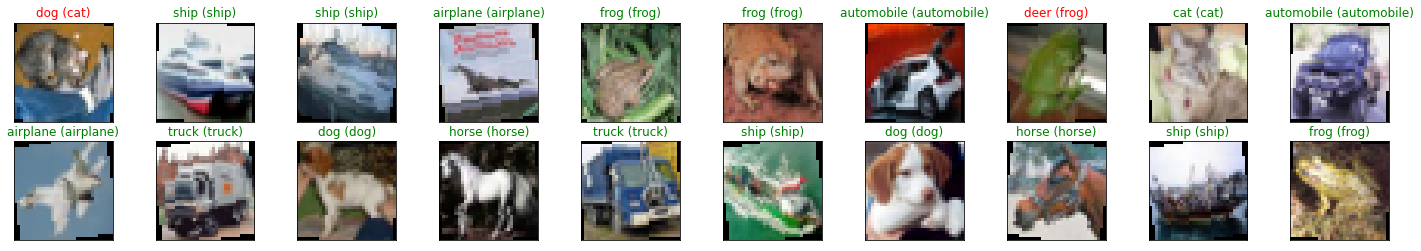

In [61]:
# Plot das previsões
fig = plt.figure(figsize = (25, 4))
print("\nEntre parênteses a classe real. Vermelho indica erro do modelo.\n")
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]), 
                 color = ("green" if preds[idx] == labels[idx].item() else "red"))